<a href="https://colab.research.google.com/github/Iman24474/Emotion_AI_Python/blob/main/1_Identifying_Facial_Key_Points.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Step 1: Import Required Libraries and Load Datasets

In [3]:
# Mount the drive
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
%cd /content/drive/MyDrive/EmotionAI/

/content/drive/MyDrive/EmotionAI


In [6]:
# Import the necessary packages
import pandas as pd
import numpy as np
import os
import PIL
import seaborn as sns
import pickle
from PIL import *
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.python.keras import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from keras import optimizers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from google.colab.patches import cv2_imshow

In [21]:
# Load facial key points data
key_facial_df = pd.read_csv('data.csv')

# Get the concise summary of the dataFrame.
key_facial_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2140 entries, 0 to 2139
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_center_x          2140 non-null   float64
 1   left_eye_center_y          2140 non-null   float64
 2   right_eye_center_x         2140 non-null   float64
 3   right_eye_center_y         2140 non-null   float64
 4   left_eye_inner_corner_x    2140 non-null   float64
 5   left_eye_inner_corner_y    2140 non-null   float64
 6   left_eye_outer_corner_x    2140 non-null   float64
 7   left_eye_outer_corner_y    2140 non-null   float64
 8   right_eye_inner_corner_x   2140 non-null   float64
 9   right_eye_inner_corner_y   2140 non-null   float64
 10  right_eye_outer_corner_x   2140 non-null   float64
 11  right_eye_outer_corner_y   2140 non-null   float64
 12  left_eyebrow_inner_end_x   2140 non-null   float64
 13  left_eyebrow_inner_end_y   2140 non-null   float

In [22]:
# Check for existance of null values
key_facial_df.isnull().sum()

,0
left_eye_center_x,0
left_eye_center_y,0
right_eye_center_x,0
right_eye_center_y,0
left_eye_inner_corner_x,0
left_eye_inner_corner_y,0
left_eye_outer_corner_x,0
left_eye_outer_corner_y,0
right_eye_inner_corner_x,0
right_eye_inner_corner_y,0


In [24]:
key_facial_df['Image'].shape

(2140,)

Since values for the image are given as space-separated string, separate the values using ' ' as separator.

Then, convert this into numpy array using `np.fromstring()` and `reshape()` the obtained 1D array into 2D array of shape (96,96)

In [25]:
key_facial_df['Image'] = key_facial_df['Image'].apply(lambda x: np.fromstring(x, dtype=int, sep=' ').reshape(96,96))

In [26]:
# Get the Image shape
key_facial_df['Image'][0].shape

(96, 96)

In [27]:
# Get the average, min, and max of a variable
key_facial_df['right_eye_center_x'].describe()

,right_eye_center_x
count,2140.000000
mean,29.640269
std,2.051575
min,18.922611
25%,28.472224
50%,29.655440
75%,30.858673
max,42.495172


### Step 2: Generate Image Visualization

Plot a random image from the dataset along with facial keypoints.

The image data is retrieved from `df['Image']` and shown using `plt.imshow()`. The facial keypoints consist of 15 pairs of x and y coordinates.

Since x-coordinates are located in even columns (e.g., 0, 2, 4, ...) and y-coordinates are in odd columns (e.g., 1, 3, 5, ...), their values are accessed using the `.loc` command, which fetches the coordinates for the image based on the corresponding column.

<ipython-input-33-871153ff4fda>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(key_facial_df.loc[i][j-1], key_facial_df.loc[i][j], 'rx')


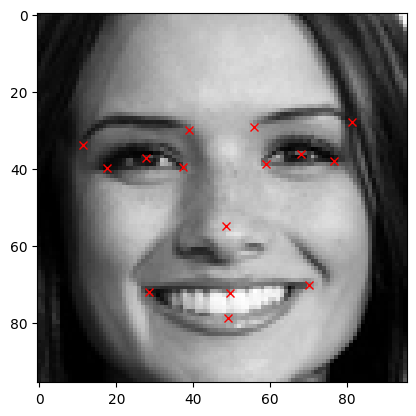

In [33]:
# Pick a random number
i = np.random.randint(1,len(key_facial_df))

# Show the image
plt.imshow(key_facial_df['Image'][i], cmap='gray')

# Add marks to the image
for j in range(1,31,2):
  # plot x and y coordinates
  plt.plot(key_facial_df.loc[i][j-1], key_facial_df.loc[i][j], 'rx')

<ipython-input-38-a2e72ae6d790>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(key_facial_df.loc[i][j-1], key_facial_df.loc[i][j], 'rx')


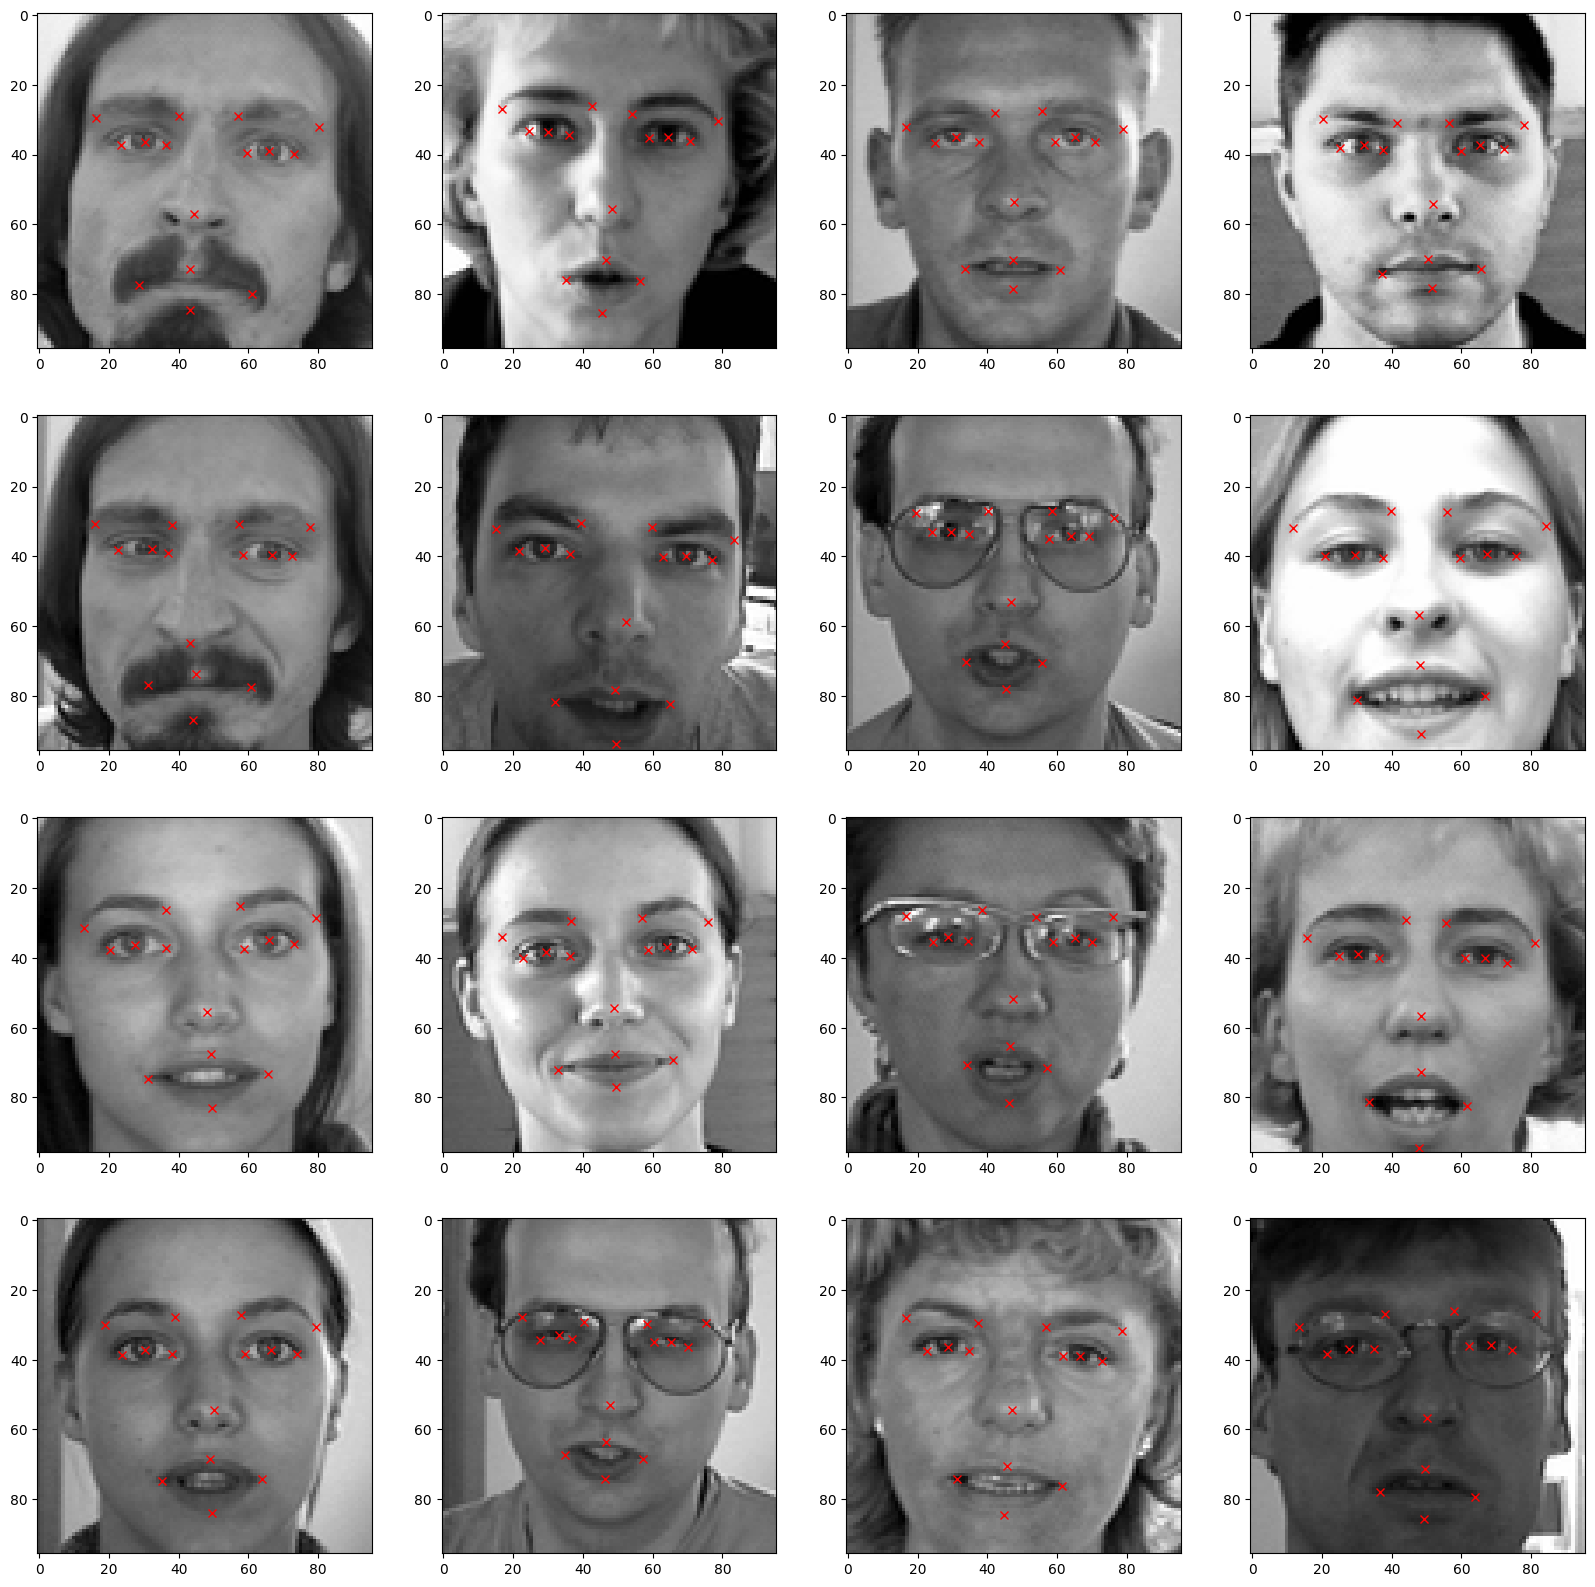

In [38]:
# Display more images in a grid format
fig = plt.figure(figsize=(20,20))

img_quantities = 16

for i in range(img_quantities):
  # subplot with 4 rows, 4 columns, and the index i+1 is used to specify the position of the subplot within a grid layout.
  ax = fig.add_subplot(4,4,i+1)
  image = plt.imshow(key_facial_df['Image'][i], cmap='gray')
  for j in range(1,31,2):
    plt.plot(key_facial_df.loc[i][j-1], key_facial_df.loc[i][j], 'rx')

<ipython-input-45-59bf9fad74d8>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(key_facial_df.loc[r][j-1], key_facial_df.loc[r][j], 'rx')


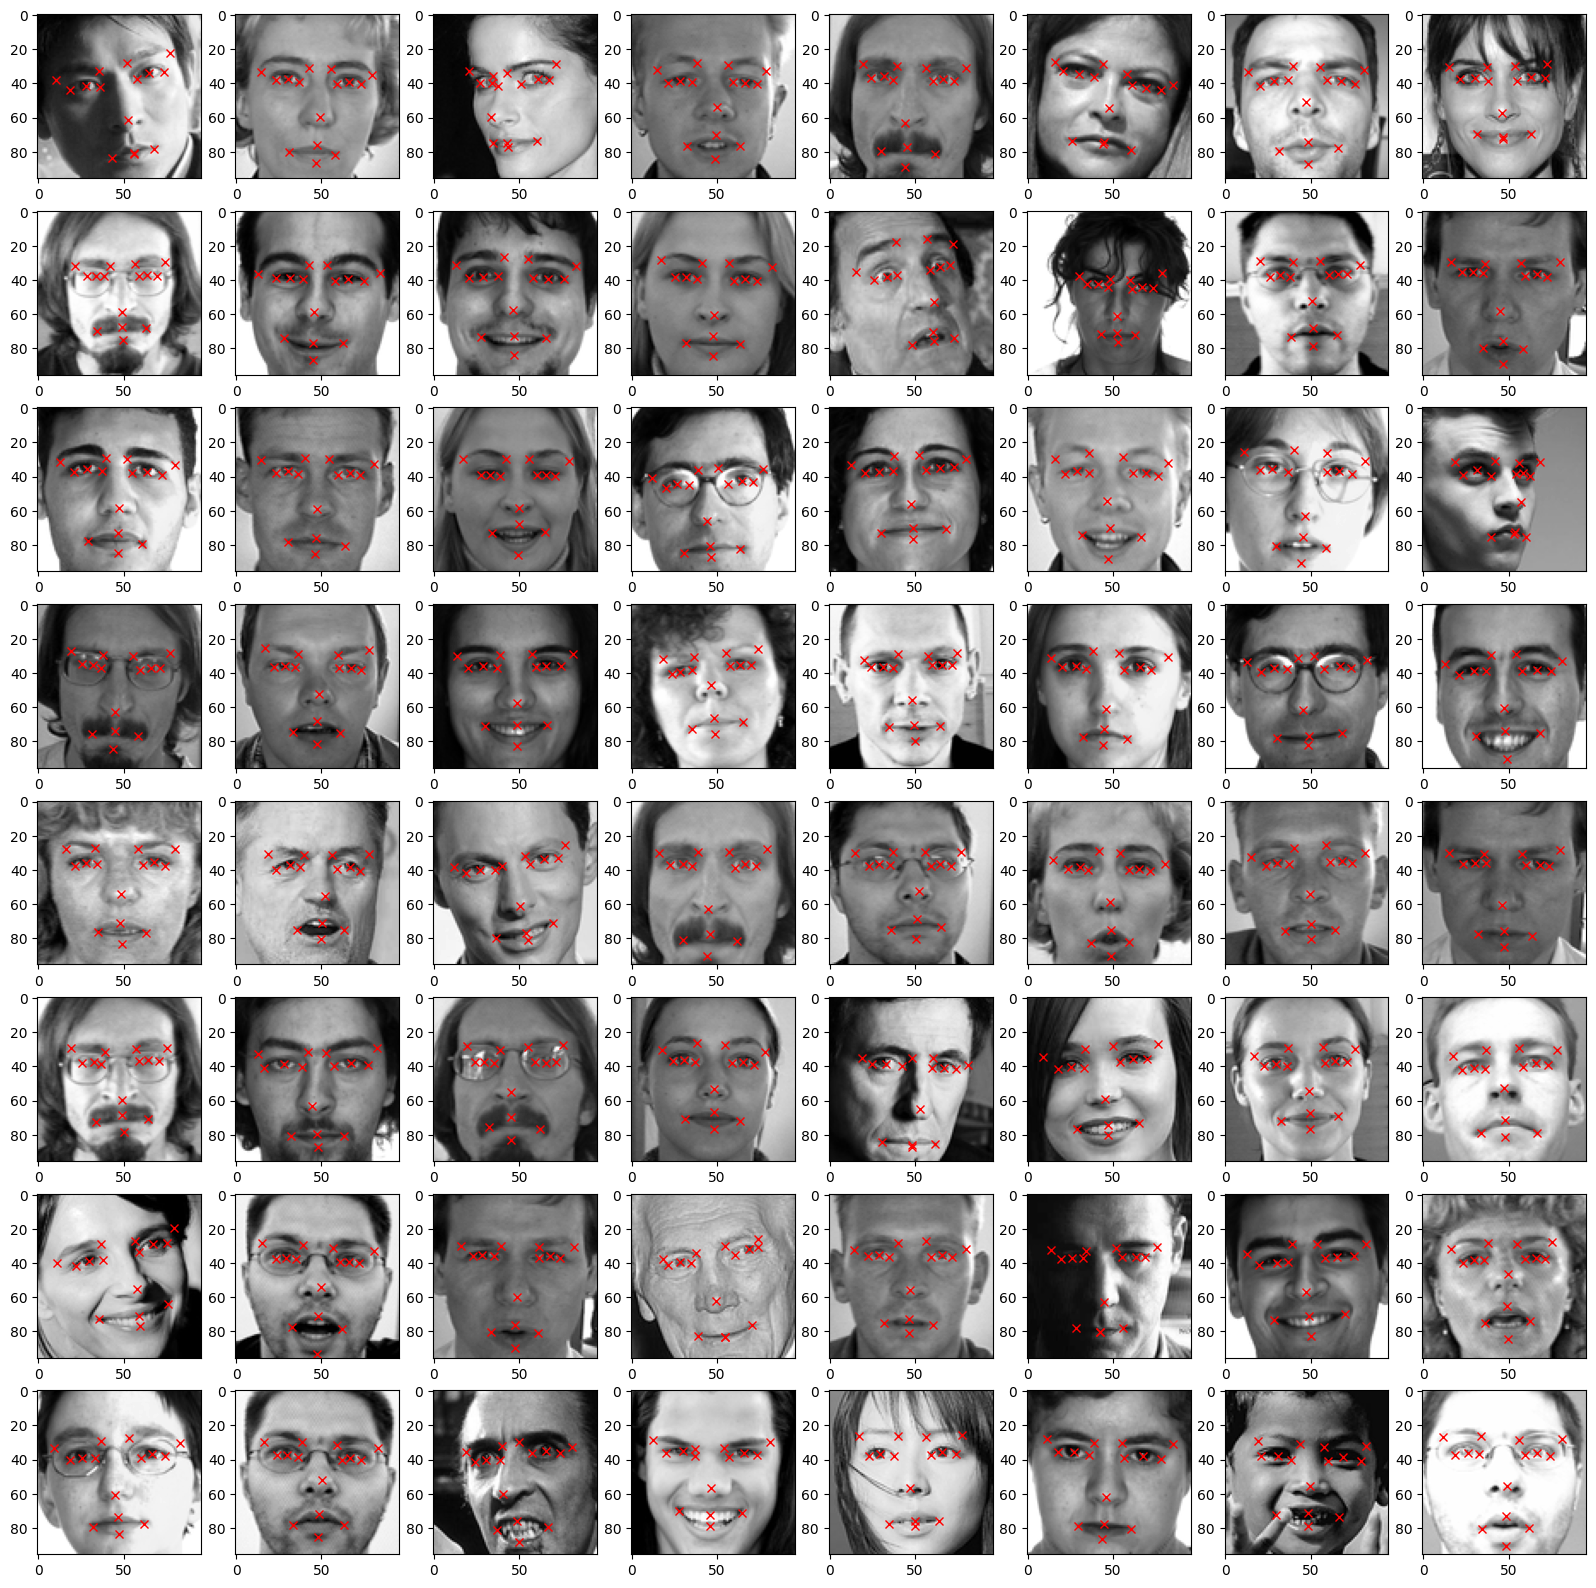

In [45]:
# Perform a sanity check on the data by randomly visualizing 64 new images along with their corresponding key points.

fig = plt.figure(figsize=(20,20))

for i in range(64):
  r = np.random.randint(1,len(key_facial_df))
  ax = plt.subplot(8,8,i+1)
  image = plt.imshow(key_facial_df['Image'][r], cmap='gray')
  for j in range(1,31,2):
    plt.plot(key_facial_df.loc[r][j-1], key_facial_df.loc[r][j], 'rx')

